<a href="https://colab.research.google.com/github/samollari/cs545-face-detection-project/blob/main/Image_Enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [410]:
file_name = "000094.png" # @param {"type":"string"}


# Setup

In [411]:
import cv2
import numpy as np
from matplotlib import pyplot as plt, colors
import math
from functools import partial
from PIL import Image

In [412]:
p_image = cv2.imread(file_name)
yuv_image = cv2.cvtColor(p_image, cv2.COLOR_BGR2YUV)
image = np.asarray(yuv_image)
print(image.dtype)
print(image.shape)

h,w,_ = image.shape
max_dim = max(h, w)

if max_dim > 512:
    scale_factor = 512 / max_dim
    image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)
    print(image.shape)

def y_channel(image):
    return image[:,:,0]

def rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_YUV2RGB)

def grayscale_image(image, fig=plt):
    fig.imshow(y_channel(image), cmap='gray', vmin=0, vmax=255)
    return fig

def color_image(image, fig=plt):
    fig.imshow(rgb(image), vmin=0, vmax=255)
    return fig

uint8
(512, 512, 3)


# Show Input

<Axes: >

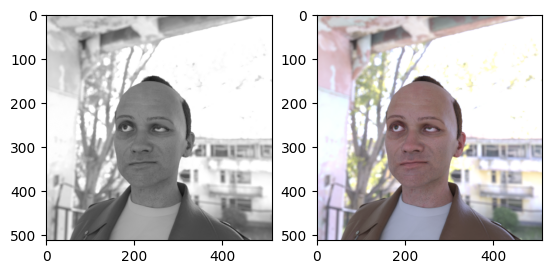

In [413]:
ax, fig = plt.subplots(1, 2)
grayscale_image(image, fig[0])
color_image(image, fig[1])

# Helpers

## Histogram

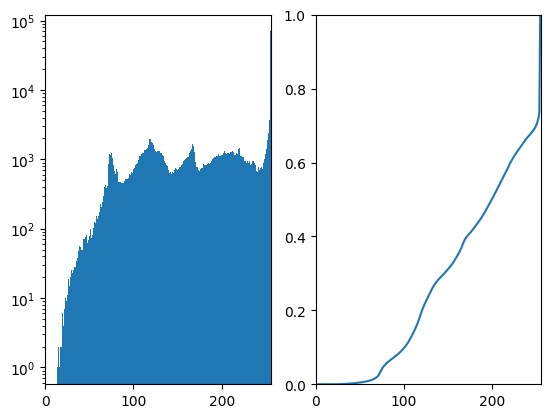

In [414]:
def show_hist(image, fig = plt):
    hst, bins, _ = fig.hist(y_channel(image).flat, bins=np.arange(256), histtype="stepfilled", log=True)
    fig.set_xlim([0, 255])
    return hst, bins


def show_cdf(hst, bins, fig = plt):
    cdf = np.cumsum(hst)
    fig.plot(bins[:-1], cdf / cdf[-1])
    fig.set_xlim([0, 255])
    fig.set_ylim([0, 1])
    return cdf

def show_hist_cdf(image):
    ax, fig = plt.subplots(1, 2)

    hst, bins = show_hist(image, fig[0])
    cdf = show_cdf(hst, bins, fig[1])
    return hst, bins, cdf

hst, bins, cdf = show_hist_cdf(image)

### Color Histogram

In [415]:
def show_hist_color(image, fig=plt):
    def draw(vals, color, fig):
        hst, bins = np.histogram(vals, np.arange(256))
        # fig.hist(vals, bins=np.arange(256), histtype="stepfilled", log=True, color=color)
        fig.bar(bins[:-1], hst, width=1, color=(color, 0.5), log=True)
        return hst

    red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2]

    r_hst = draw(red, 'r', fig)
    g_hst = draw(green, 'g', fig)
    b_hst = draw(blue, 'b', fig)
    fig.set_xlim([0, 255])
    return r_hst, g_hst, b_hst

def show_cdf_color(r_hst, g_hst, b_hst, fig=plt):
    def draw(hst, color, fig):
        cdf = np.cumsum(hst)
        fig.plot(np.arange(255), cdf / cdf[-1], color=color)
        return cdf

    r_cdf = draw(r_hst, 'r', fig)
    g_cdf = draw(g_hst, 'g', fig)
    b_cdf = draw(b_hst, 'b', fig)
    fig.set_xlim([0, 255])
    fig.set_ylim([0, 1])
    return r_cdf, g_cdf, b_cdf

def show_hist_cdf_color(image):
    ax, fig = plt.subplots(1, 2)
    r_hst, g_hst, b_hst = show_hist_color(rgb(image), fig[0])
    r_cdf, g_cdf, b_cdf = show_cdf_color(r_hst, g_hst, b_hst, fig[1])
    return r_hst, g_hst, b_hst, r_cdf, g_cdf, b_cdf

# _ = show_hist_cdf_color(image)

## Waveform

In [416]:
dir='h'
def origin(dif):
    return 'lower' if dir=='h' else 'upper'

def waveform(image, dir='h', fig=plt):
    image = y_channel(image)
    img = image.transpose() if dir=='h' else image
    waveform = np.asarray([np.histogram(row, np.arange(256))[0] for row in img])
    wfm = waveform.transpose() if dir=='h' else waveform
    fig.imshow(wfm, origin=origin(dir), norm='symlog', cmap='gray')

# waveform(image, dir)

### Color Waveform

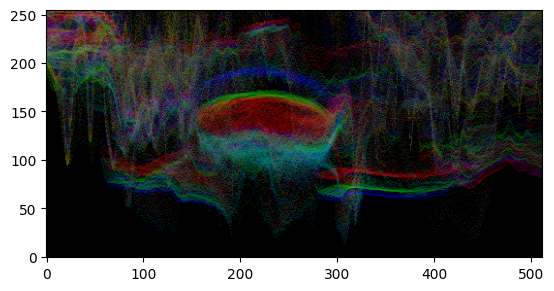

In [417]:
def waveform_color(image, dir='h', fig=plt):
    def h(vals, c):
        return np.histogram(vals[:, c], np.arange(256))[0]

    image = rgb(image)
    ctimage = image.transpose([1,0,2]) if dir=='h' else image
    rgbwaveform = np.asarray([(h(row, 0), h(row, 1), h(row, 2)) for row in ctimage]).transpose([0,2,1])
    maxoccurences = np.max(rgbwaveform)
    norm = colors.SymLogNorm(1)
    # rgbwaveform = [[norm(clrs) for clrs in rgbwaveform] for row in rgbwaveform]
    rgbwaveform = np.log(rgbwaveform + 1)
    maxlog = np.max(rgbwaveform)
    rgbwaveform = rgbwaveform / (maxlog * 1)

    fig.imshow(rgbwaveform.transpose([1,0,2]) if dir=='h' else rgbwaveform, origin=origin(dir))

waveform_color(image, dir)

## Mean Square Error

In [418]:
def mse(image1, image2):
    return np.mean((image1 - image2) ** 2) / len(image1)

## Copy image passed in

In [419]:
# prompt: Write a decorator function that calls np.copy on the first argument passed in

import functools

def copy(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        if args:
            copied_args = (np.copy(args[0]),) + args[1:]
            return func(*copied_args, **kwargs)
        return func(*args, **kwargs)
    return wrapper


## Pass in grayscale image

In [420]:
# prompt: Write a decorator function @grayscale that passes in the output of y_channel(...) of the first argument passed in

def grayscale(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        if args:
            grayscale_img = y_channel(args[0])
            return func(grayscale_img, *args[1:], **kwargs)  # Pass grayscale image
        return func(*args, **kwargs)
    return wrapper


## Compare Images

In [421]:
def show_cmp(image1, image2):
    ax, fig = plt.subplots(2, 2)
    grayscale_image(image1, fig[0, 0])
    grayscale_image(image2, fig[0, 1])
    color_image(image1, fig[1, 0])
    color_image(image2, fig[1, 1])

In [422]:
def show_grayscale_cmp(image1, image2):
    ax, fig = plt.subplots(1, 2)
    fig[0].imshow(image1, cmap='gray', vmin=0, vmax=255)
    fig[1].imshow(image2, cmap='gray', vmin=0, vmax=255)

In [423]:
def cmp_images(image1, image2):
    ax, fig = plt.subplots(3, 2)
    waveform(image1, fig=fig[0,0])
    waveform(image2, fig=fig[0,1])
    i_hst, i_bins = show_hist(image1, fig=fig[1,0])
    c_hst, c_bins = show_hist(image2, fig=fig[1,1])
    show_cdf(i_hst, i_bins, fig=fig[2,0])
    _ = show_cdf(c_hst, c_bins, fig=fig[2,1])

    print(mse(y_channel(image1), y_channel(image2)))
    print(mse(rgb(image1), rgb(image2)))

## Noise

In [424]:
@copy
def dither(image, scale=2.0):
    y = y_channel(image)
    image[:,:,0] = np.clip(y + np.random.normal(scale=scale, size=y.shape), 0, 255)
    return image

# Contrast Adjustment

## Basic Contrast Adjustment

14 255
1.058091286307054


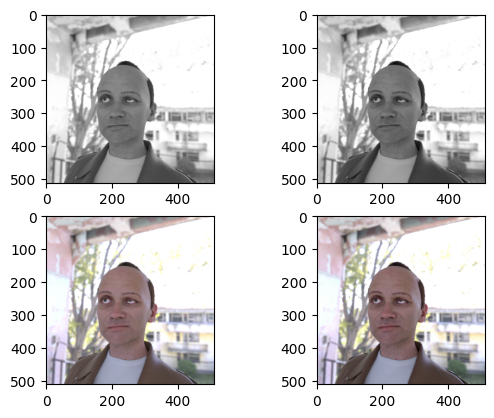

In [425]:
@copy
def basic_contrast(image):
    y = y_channel(image)
    minval = np.min(y)
    maxval = np.max(y)
    print(minval, maxval)

    scale_factor = 255 / (maxval - minval)
    print(scale_factor)
    image[:,:,0] = ((y - minval) * scale_factor).clip(0, 255)
    return image

new_image = basic_contrast(image)

show_cmp(image, new_image)

0.06309936195611954
0.06308641036351521


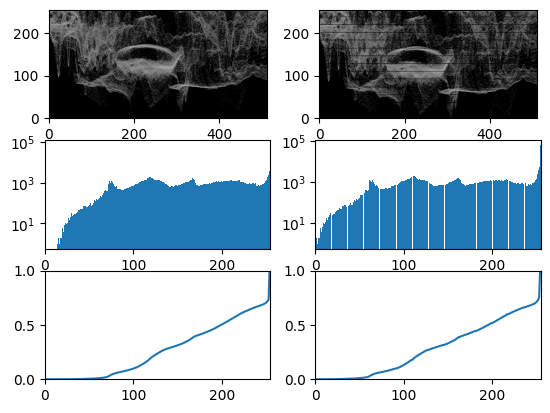

In [426]:
cmp_images(image, new_image)

## Modified Contrast Adjustment

110.0 255.0
1.7586206896551724


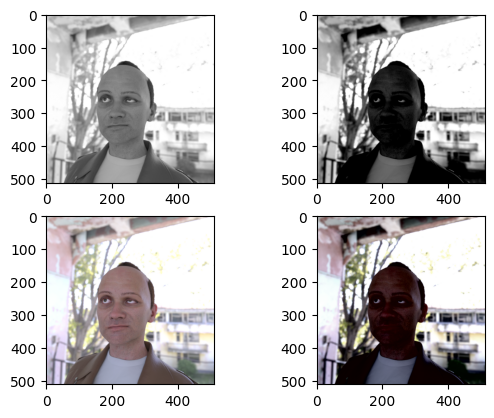

In [427]:
@copy
def modified_contrast(image):
    y = y_channel(image)
    pct_10_val = np.percentile(image, 5)
    pct_90_val = np.percentile(image, 95)
    print(pct_10_val, pct_90_val)

    mod_scale_factor = 255 / (pct_90_val - pct_10_val)
    print(mod_scale_factor)
    image[:,:,0] = ((y - pct_10_val) * mod_scale_factor).clip(0, 255)
    return image

mod_new_image = modified_contrast(image)

show_cmp(image, mod_new_image)

0.15563778579235077
0.15374195327361426


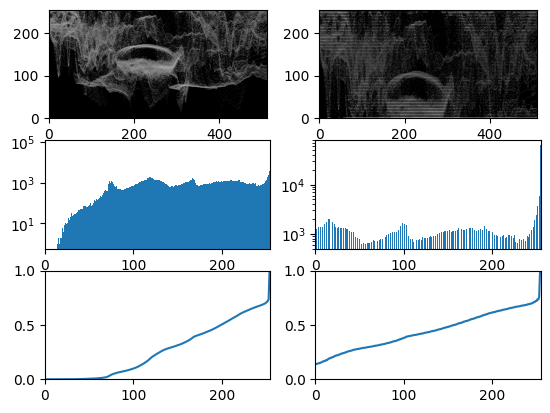

In [428]:
cmp_images(image, mod_new_image)

# Histogram Equalization

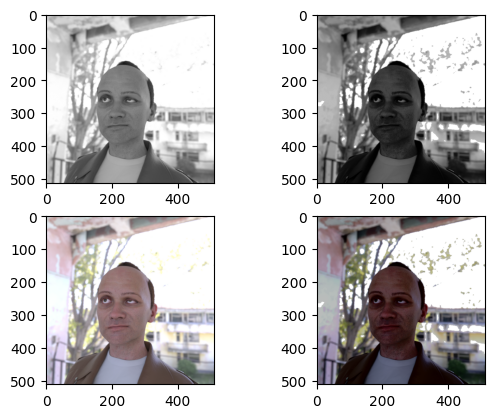

In [429]:
@copy
def hist_eq(image):
    h,w,_ = image.shape
    def histogram_equalization(cdf, sizeprod, val):
        return math.floor((cdf[val - 1] if val != 0 else cdf[val]) * 255/sizeprod)

    vec_hst_eq = np.vectorize(partial(histogram_equalization, cdf, h * w))
    image[:,:,0] = vec_hst_eq(y_channel(image))
    return image

vec_hst_eq_image = hist_eq(image)

show_cmp(image, vec_hst_eq_image)

0.16743289679288864
0.1683824509382248


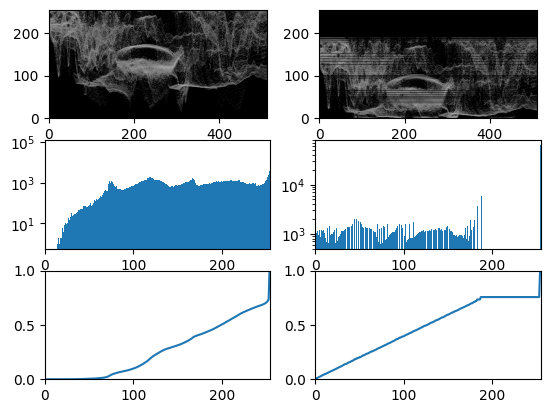

In [430]:
cmp_images(image, vec_hst_eq_image)

# Kayla's Enhancement Code

## Skew Correction

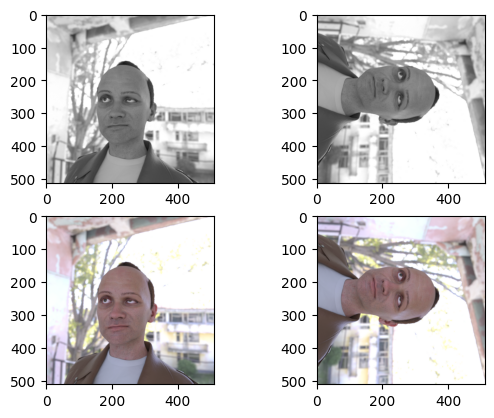

In [431]:
def deskew(image):
    co_ords = np.column_stack(np.where(y_channel(image) > 0))
    angle = cv2.minAreaRect(co_ords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

deskewed = deskew(image)
show_cmp(image, deskewed)

## Noise Reduction

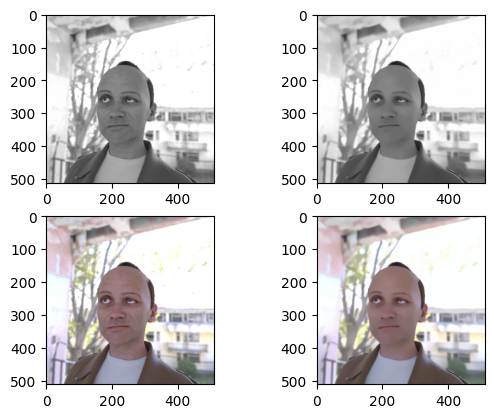

In [432]:
def remove_noise(image):
    return cv2.fastNlMeansDenoisingColored(image, None)

def agressive_denoise(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 15)

denoised = remove_noise(image)
show_cmp(image, denoised)

# Canny Edge Detection

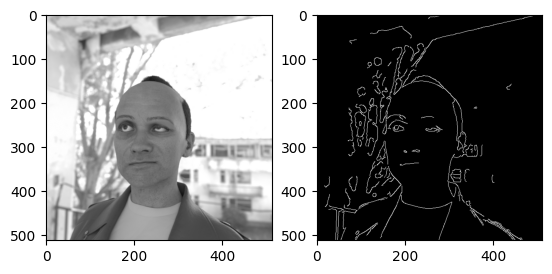

In [433]:
@grayscale
def edge_detect(image):
    return cv2.Canny(image, 100, 200)

edge_image = edge_detect(image)
show_grayscale_cmp(y_channel(image), edge_image)

# Compare Basic Contrast and Histogram Equalization

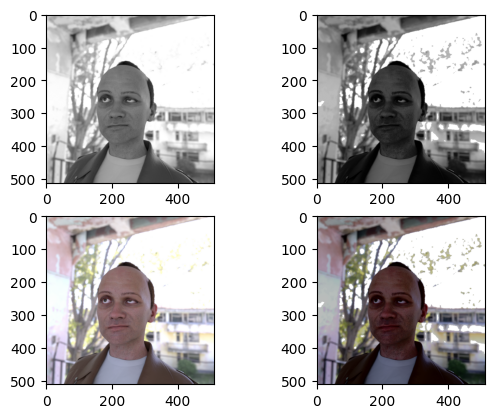

In [434]:
show_cmp(new_image, vec_hst_eq_image)

0.1305118352174759
0.12896638115247092


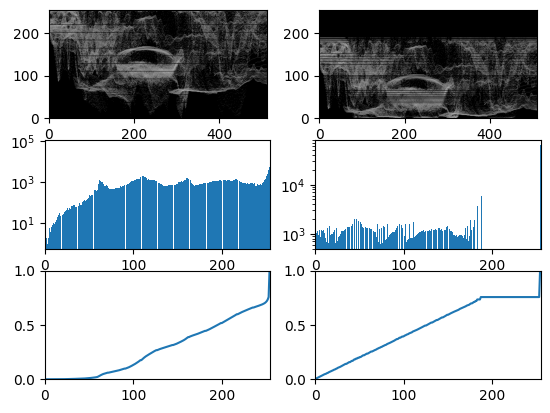

In [435]:
cmp_images(new_image, vec_hst_eq_image)

# Pipeline
Basic Contrast -> Dither -> Denoise -> Hist EQ -> Dither -> Denoise

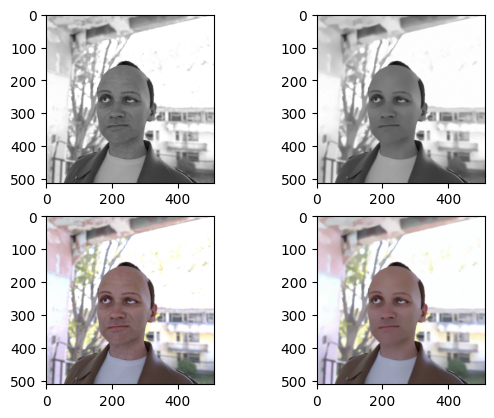

In [436]:
dithered_contrast = remove_noise(dither(new_image))

show_cmp(new_image, dithered_contrast)

0.029155954718589783
0.03926364332437515


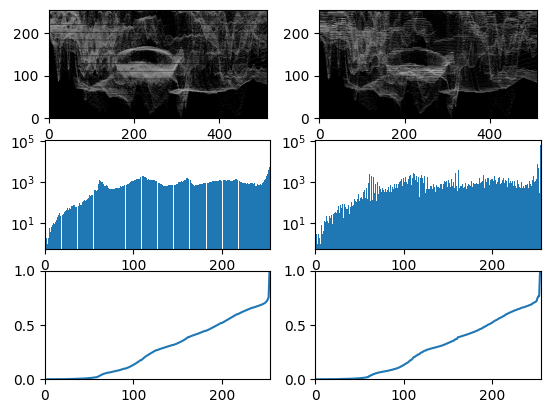

In [437]:
cmp_images(new_image, dithered_contrast)

0 187
1.3636363636363635


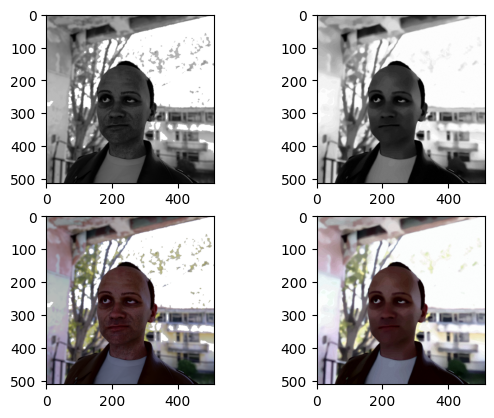

In [438]:
image_pipelined = dither(basic_contrast(hist_eq(dithered_contrast)))
# image_pipelined = hist_eq(dithered_contrast)

show_cmp(vec_hst_eq_image, image_pipelined)

0.13400647044181824
0.13448024044434229


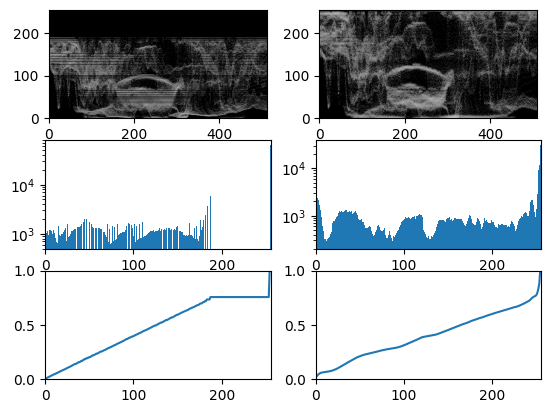

In [439]:
cmp_images(vec_hst_eq_image, image_pipelined)

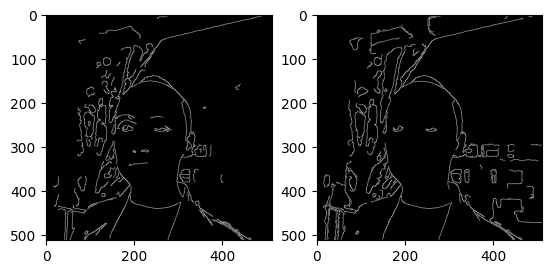

In [440]:
edges = edge_detect(image_pipelined)
show_grayscale_cmp(edge_image, edges)